In [1]:
#!pip install plotly
#!pip install joypy

# Florian Guillot : Project 4
### Uber Pickups
### Jedha Full Stack, dsmf-paris-13
### 07-2021

# **As this notebook uses plotly interactive charts, please read it with : https://nbviewer.jupyter.org/**

# **1) Initialization**
----
## **1.1) We begin with the Import of the different libraries we will use and their configurations**
----

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import joypy

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

from matplotlib import cm

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE

## **1.2) Data collection**
---

### We first import the different files and merge them. We decide to work with the year 2014 to avoid the 500Mo+ file of 2015 data

In [3]:
raw_data = pd.read_csv('Data/uber-raw-data-apr14.csv')
for month in ['aug','jul','jun','may','sep']:
    raw_data = pd.concat([raw_data, pd.read_csv('Data/uber-raw-data-'+month+'14.csv')])

# **2) Preprocessing & DEA**
---

## **2.1) Dataset Overview**
---

In [4]:
print('Shape of the dataset :\n',raw_data.shape)
raw_data.head()

Shape of the dataset :
 (4534327, 4)


Date/Time      Lat      Lon    Base
0  4/1/2014 0:11:00  40.7690 -73.9549  B02512
1  4/1/2014 0:17:00  40.7267 -74.0345  B02512
2  4/1/2014 0:21:00  40.7316 -73.9873  B02512
3  4/1/2014 0:28:00  40.7588 -73.9776  B02512
4  4/1/2014 0:33:00  40.7594 -73.9722  B02512

In [5]:
raw_data.describe()

Lat           Lon
count  4.534327e+06  4.534327e+06
mean   4.073926e+01 -7.397302e+01
std    3.994991e-02  5.726670e-02
min    3.965690e+01 -7.492900e+01
25%    4.072110e+01 -7.399650e+01
50%    4.074220e+01 -7.398340e+01
75%    4.076100e+01 -7.396530e+01
max    4.211660e+01 -7.206660e+01

## **2.2) First transformations**
---

### We transform the date information to make it impactful for our clustering : we keep day of the week and hour in the day.

In [6]:
# Sample to reduce calculus time
df = raw_data.sample(40000)
df = df.drop('Base', axis = 1)

In [7]:
#First we create to columns with the hour and the day of the week

df['Date'] = pd.to_datetime(df['Date/Time'])
df = df.drop('Date/Time', axis = 1)
df['Hour'] = df['Date'].dt.hour
df['Day'] = df['Date'].dt.dayofweek
df = df.drop('Date', axis=1)

### We create a new column weekfloat, it we will be a combination of both hour and day of the week : hour/(24)+weekday = weekfloat. It create a continuous variable that will explicit where we are in the week and the day

In [8]:
df['Weekfloat'] = df['Hour']/(24) + df['Day']

### We polarize the column Weekfloat to make it circular and continuous

In [9]:
df['WeekfloatX']=np.sin(2*np.pi*df.Weekfloat)
df['WeekfloatY']=np.cos(2*np.pi*df.Weekfloat)

### For the column Day, we replace the day numbers by the true days names

In [10]:
df['DayNumber'] = df['Day']
df['Day'].replace({0 : 'Monday',1 : 'Tuesday',2 : 'Wednesday',3 : 'Thursday',4 : 'Friday',5 : 'Saturday',6 : 'Sunday'}, inplace = True)

In [11]:
df.head()

Lat      Lon  Hour       Day  Weekfloat  WeekfloatX    WeekfloatY  \
234710  40.7621 -73.9706    16  Thursday   3.666667   -0.866025 -5.000000e-01   
618285  40.7543 -73.9674    21  Saturday   5.875000   -0.707107  7.071068e-01   
993306  40.7672 -73.9683    17    Friday   4.708333   -0.965926 -2.588190e-01   
387888  40.7369 -73.9905    15   Tuesday   1.625000   -0.707107 -7.071068e-01   
503542  40.6922 -73.9865     6    Friday   4.250000    1.000000 -7.354071e-16   

        DayNumber  
234710          3  
618285          5  
993306          4  
387888          1  
503542          4

## **2.3) DEA**
---

In [12]:
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(df, kind="scatter", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show();

<Figure size 800x640 with 0 Axes>

### Let's vizualize the different pickups on a map

In [13]:
fig = px.scatter_mapbox(df, lat="Lat", lon="Lon", zoom=8, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show();

### What are the impacts of the day and the hour here ? We begin to plot the density of pickups by hour.

In [14]:
N = 23
bottom = 2
arr = df['Hour'].values

# create theta for 24 hours
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

# make the histogram that bined on 24 hour
radii, tick = np.histogram(arr, bins = 23)

# width of each bin on the plot
width = (2*np.pi) / N

# make a polar plot
plt.figure(figsize = (8, 5))
ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom)

# set the lable go clockwise and start from the top
ax.set_theta_zero_location("N")
# clockwise
ax.set_theta_direction(-1)

# set the label
ticks = ['0:00', '3:00', '6:00', '9:00', '12:00', '15:00', '18:00', '21:00']
ax.set_xticklabels(ticks)

# set options
ax.set_title('Density of pickups per hour')

plt.show();

<ipython-input-14-5586a7984dd0>:26: UserWarning:

FixedFormatter should only be used together with FixedLocator



### Then we plot the density of pickups per Day

In [15]:
order = ['Monday','Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

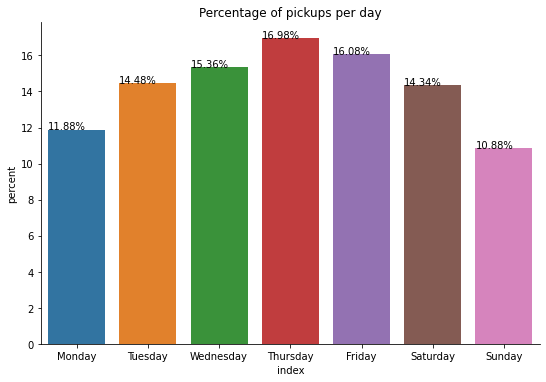

In [16]:
df1 = df['Day'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x='index',y='percent',data=df1,order = order, kind = 'bar',height=5, aspect=12/8)
g.set(title = 'Percentage of pickups per day')
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    
plt.show();

### Then let's focus on the relations between Hour and WeekDay

In [17]:
# Draw Plot
plt.figure(figsize=(12,8), dpi= 80)
fig, axes = joypy.joyplot(df, column=['Hour'], by="Day", ylim='own', figsize=(14,10), colormap = cm.autumn_r, linecolor="blue", labels = order)

# Decoration
plt.title('Repartition od pickups per hour depending of the day', fontsize=22)
plt.xlabel('Hour',  fontsize=16, color='darkred', alpha=1)
plt.ylabel('Day in the week', fontsize=26,  color='grey', alpha=0.8)
plt.show();

<Figure size 960x640 with 0 Axes>

### Now we will vizualize our created column Weekfloat

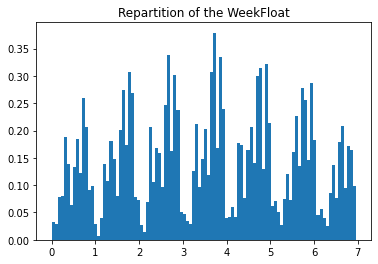

In [18]:
plt.hist(df.Weekfloat, density = True, bins = 100, histtype='stepfilled')
plt.title('Repartition of the WeekFloat')
plt.show();

### As last plot, we will vizualize the relations wetween weekday and weekfloats, per hour

In [19]:
# Draw Plot
plt.figure(figsize=(12,8), dpi= 80)
fig, axes = joypy.joyplot(df, column=['DayNumber', 'Weekfloat'], by="Hour", ylim='own', figsize=(10,15), linecolor="blue", legend = True)

# Decoration
plt.title('Joy Plot of Weekday and Weekfloat per hour', fontsize=22)
plt.xlabel('Day',  fontsize=16, color='darkred', alpha=1)
plt.ylabel('Hour in the day', fontsize=26,  color='grey', alpha=0.8)
plt.show();

<Figure size 960x640 with 0 Axes>

### We can see here Weekfloat a bit shifted to the right. We can explain this phenomena because we have straightened the pickups distribution by adding the hours data. Profile between the variables is similar

# **3) First model : KMEANS**
---

## **3.1) We begin with Elbow kmean**
---

In [20]:
#In a first time we use only lat et lon as features for X
X = df[['Lat', 'Lon','WeekfloatX', 'WeekfloatY']]

In [21]:
## Apply standard scaler 
sc = StandardScaler()
X = sc.fit_transform(X)

In [22]:
# Let's create a loop that will collect the Within-sum-of-square (wcss) for each value K 
# Let's use .inertia_ parameter to get the within sum of square value for each value K 
wcss =  []
k = []
for i in range (3,20): 
    kmeans = KMeans(n_clusters= i, init = "k-means++", random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    k.append(i)
    print("WCSS for K={} --> {}".format(i, wcss[-1]))
    
# Let's visualize using plotly
# Create DataFrame
wcss_frame = pd.DataFrame(wcss)
k_frame = pd.Series(k)

# Create figure
fig= px.line(
    wcss_frame,
    x=k_frame,
    y=wcss_frame.iloc[:,-1]
)

# Create title and axis labels
fig.update_layout(
    yaxis_title="Inertia",
    xaxis_title="# Clusters",
    title="Inertia per cluster"
)

# Render
fig.show(renderer="notebook")

WCSS for K=3 --> 99799.03507113727
WCSS for K=4 --> 80382.77155302395
WCSS for K=5 --> 71581.26052843971
WCSS for K=6 --> 64178.69132828186
WCSS for K=7 --> 58006.11259849728
WCSS for K=8 --> 53924.52533418043
WCSS for K=9 --> 49844.596519519466
WCSS for K=10 --> 46605.606585438385
WCSS for K=11 --> 43564.48321604261
WCSS for K=12 --> 41140.04637372866
WCSS for K=13 --> 38844.38748675739
WCSS for K=14 --> 36944.74139163102
WCSS for K=15 --> 34981.56671383359
WCSS for K=16 --> 33254.20224463289
WCSS for K=17 --> 32206.93495317824
WCSS for K=18 --> 30743.584737158104
WCSS for K=19 --> 29641.10230793134


## **3.2) We now use Silhouette to decide the number of K clusters**
---

In [23]:
sil = []
k = []

for i in range (3,11): 
    kmeans = KMeans(n_clusters= i, init = "k-means++", random_state = 0)
    kmeans.fit(X)
    sil.append(silhouette_score(X, kmeans.predict(X)))
    k.append(i)
    print("Silhouette score for K={} is {}".format(i, sil[-1]))
    
# Create a data frame 
cluster_scores=pd.DataFrame(sil)
k_frame = pd.Series(k)

# Create figure
fig = px.bar(data_frame=cluster_scores,  
             x=k, 
             y=cluster_scores.iloc[:, -1]
            )

# Add title and axis labels
fig.update_layout(
    yaxis_title="Silhouette Score",
    xaxis_title="# Clusters",
    title="Silhouette Score per cluster"
)

# Render
fig.show(renderer="notebook") 

Silhouette score for K=3 is 0.33492987052347445
Silhouette score for K=4 is 0.3245712738741464
Silhouette score for K=5 is 0.33334299105647197
Silhouette score for K=6 is 0.2981748687922181
Silhouette score for K=7 is 0.30662004145280597
Silhouette score for K=8 is 0.300562474184866
Silhouette score for K=9 is 0.27492333139842784
Silhouette score for K=10 is 0.2759883861723423


### We will use K= 5 as number of clusters

## **3.3) Training the model**
---

In [24]:
# Instanciate KMeans with k=5 and initialisation with k-means++
kmeans = KMeans(n_clusters=5, random_state=0, init="k-means++")

# Fit kmeans to our dataset
kmeans.fit(X)

# Cluster centers coordinates
# Let's use inverse transform to have the real coordinates 
cluster_centers = sc.inverse_transform(kmeans.cluster_centers_)

## **3.4) Results**
---

### We plot on a map the repartition of the pickups depending the clusters

In [25]:
fig = px.scatter_mapbox(df, lat="Lat", lon="Lon", zoom=9, color = kmeans.fit_predict(X), height=300)
fig.update_layout(mapbox_style="open-street-map",
                  margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### We plot the cluster centers, the Hot zones ! 

In [26]:
fig = px.scatter_mapbox(lat = cluster_centers[:,0], lon = cluster_centers[:,1], zoom=9, size = np.unique(kmeans.fit_predict(X), return_counts=True)[1], color = np.unique(kmeans.fit_predict(X), return_counts=True)[0], height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### We plot the repartition of the pickups regarding the day in a 3d plot

In [27]:
fig = px.scatter_3d(df, x='Lat', y='Lon', z='Day',color=kmeans.fit_predict(X))
fig.show()

### What about the importance of the hours? 

In [28]:
fig = px.scatter_3d(df, x='Lat', y='Lon', z='Hour',color=kmeans.fit_predict(X))
fig.show()

### We observe here there are two clusters with the coordinates lat & lon as most important value, and 3 clusters with the Hour as the most important value

# **4) Second model : DBSCAN**
---

## **4.1) Preprocessing**
---

In [29]:
X = df[['Lat', 'Lon','WeekfloatX', 'WeekfloatY']]

In [30]:
sc2 = StandardScaler()
X = sc2.fit_transform(X)

## **4.2) Training the model**
---

In [31]:
# We have tried e in [0.01 to 10] and k = [10 to 5000] and the result are not as clear as they are for kmean method
e = 0.6
k = 50

print ('e=',e,'k=',k)
db = DBSCAN(eps=e, min_samples=k, metric="euclidean")
# Fit on data 
db.fit(X)

print('DBSCAN has created the following labels: ', set(db.labels_))

df['Clusters'] = db.labels_

print ('The model has classified as outliers',np.unique(db.labels_, return_counts=True)[1][0], 'pickups corresponding to the label -1 ' )

fig = px.scatter_mapbox(df[df['Clusters']>-1], lat="Lat", lon="Lon", zoom=9, color = df[df['Clusters']>-1].Clusters, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

e= 0.6 k= 50
DBSCAN has created the following labels:  {0, 1, 2, 3, -1}
The model has classified as outliers 1550 pickups corresponding to the label -1 


In [32]:
fig = px.scatter_3d(df[df['Clusters']>-1], x='Lat', y='Lon', z='Weekfloat',color = df[df['Clusters']>-1].Clusters)
fig.show()

### The model does not take well all the features, we will keep the Kmean model w<ith k = 5 which merged the both data : coordinates and time

# **5) KMEANS model for each day : our hot spots!**
For that we plot each day the map with the 5 hot spots and for information (we could go further with the hours. We see in the 3d plot that we could divide the day inb two different times : day and night

In [33]:
X = df[['Lat', 'Lon','WeekfloatX', 'WeekfloatY', 'DayNumber']]

In [34]:
kmeans=[]
for day in range (7):
    # Instanciate KMeans with k=5 and initialisation with k-means++
    kmeans.append(KMeans(n_clusters=5, random_state=0, init="k-means++"))
    X_day = X[X['DayNumber'] == day]
    X_day.drop('DayNumber', axis = 1, inplace = True)
    X_day = sc.fit_transform(X_day)
    # Fit kmeans to our dataset
    kmeans[day].fit(X_day)

    # Cluster centers coordinates
    # Let's use inverse transform to have the real coordinates 
    cluster_centers = sc.inverse_transform( kmeans[day].cluster_centers_)
    print("For the day:", order[day])
    fig = px.scatter_mapbox(lat = cluster_centers[:,0], lon = cluster_centers[:,1], zoom=10, size = np.unique(kmeans[day].fit_predict(X_day), return_counts=True)[1], color = np.unique(kmeans[day].fit_predict(X_day), return_counts=True)[1], height=300)
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()
    
    fig = px.scatter_3d(df[df['DayNumber'] == day], x='Lat', y='Lon', z='Weekfloat',color= kmeans[day].fit_predict(X_day))
    fig.show()

C:\Users\Flo\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



For the day: Monday


C:\Users\Flo\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



For the day: Tuesday


C:\Users\Flo\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



For the day: Wednesday


C:\Users\Flo\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



For the day: Thursday


C:\Users\Flo\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



For the day: Friday


C:\Users\Flo\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



For the day: Saturday


C:\Users\Flo\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



For the day: Sunday
